In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-08-16 12:59:29.212869: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-16 12:59:29.544084: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 12:59:30.282447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [18]:
#Coletando dados 

#######################################################

#     Este programa quando executado usa dados reconstruídos

#     Para refazer as previsões, tem que apagar os dados dos anos para prever na planilha

########################################################





df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/André - RJ_Reconstrucao_Moluscos_2024_06_25.xlsx')
df_TOTAL_MOLLUSCS_e_lulas = pd.DataFrame(df[['Ano','Lula_art','Lula_ind','Lula_art_ind']])


dados = df_TOTAL_MOLLUSCS_e_lulas[['Ano','Lula_art','Lula_art_ind']].dropna().reset_index(drop=True)


anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()

#Fazendo as proporções
for i in range(len(dados['Ano'])):
  dados.loc[i,'Prop_Lula_art'] = dados.loc[i,'Lula_art'] / dados.loc[i,'Lula_art_ind']



prop = dados['Prop_Lula_art'].values
dados.head()

,Ano,Lula_art,Lula_art_ind,Prop_Lula_art
0,1978,106.0,126.0,0.841270
1,1979,175.0,304.0,0.575658
2,1980,335.0,353.0,0.949008
3,1981,373.0,488.0,0.764344
4,1982,127.0,147.0,0.863946


In [19]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_norm = (prop - prop_mean)/prop_std

In [20]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Nadam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


#history = model.fit(anos_com_dados_norm,prop_norm, epochs=300, verbose=1)
#model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/Lulas/pesos prop lula_art/.weights.h5', overwrite=True)

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/Lulas/pesos prop lula_art/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', because it has 2 variables whereas the saved optimizer has 31 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/stepWARNING:tensorflow:5 out of the last 19 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x703d7c704940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Previsões dos dados ausentes: [[0.93683505]
 [0.9301063 ]
 [0.923396  ]
 [0.91709745]
 [0.91108346]
 [0.905318  ]
 [0.89954036

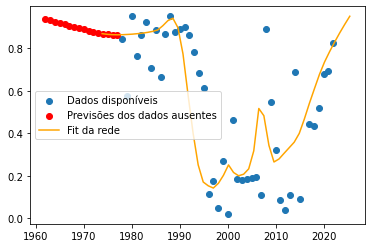

In [22]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*prop_std + prop_mean
prev_ausentes = model.predict(anos_para_prever_norm)*prop_std + prop_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0
    if prev_ausentes[i]>=1:
        prev_ausentes[i]=1

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,prop,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*prop_std + prop_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

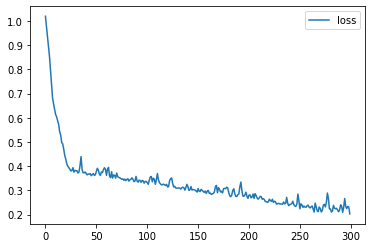

In [13]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [23]:
#Lista de anos sem buracos normalizada e sua predição      (para poder me referir por indices)

anos = np.arange(1950,np.max(anos_para_prever)+1)
anos_norm = (anos-ano_mean)/ano_std
prev_continua = model.predict(anos_norm)*prop_std + prop_mean

for i in range(len(prev_continua)):
    if prev_continua[i]<0:
        prev_continua[i]=0
    if prev_continua[i]>=1:
        prev_continua[i]=1


df_preenchido = df[['Ano','Lula_art']]
for i in range(len(prev_continua)):
    if pd.isnull(df.loc[i,'Lula_art'])==True:
      df_preenchido.loc[i,'Lula_art']=df.loc[i,'Lula_art_ind']*prev_continua[i]

df_preenchido = df_preenchido.loc[0:1977-1950,:]
with pd.option_context('display.max_rows', None,):
    print(df_preenchido)


#Planilha com os dados preenchidos
df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/Lulas/Previsão Lula_art_1962-1977.xlsx')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
     Ano    Lula_art
0   1950   29.281061
1   1951   33.240586
2   1952   36.422131
3   1953   35.573314
4   1954   31.155492
5   1955   26.000032
6   1956   29.538839
7   1957   41.198006
8   1958   26.825390
9   1959   13.212799
10  1960   23.185667
11  1961   17.970891
12  1962   27.008955
13  1963   55.378529
14  1964   65.561119
15  1965  153.795105
16  1966   19.132753
17  1967   63.372261
18  1968  541.523315
19  1969   60.971233
20  1970  138.882080
21  1971   68.556419
22  1972  128.948792
23  1973  292.803864
24  1974  409.573090
25  1975  143.930481
26  1976   64.896790
27  1977  192.410187


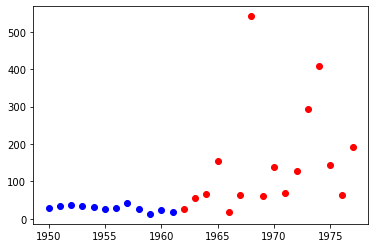

In [13]:
for i in range(len(df_preenchido['Ano'])):
  if i+1950 in anos_para_prever:
    plt.scatter(df_preenchido['Ano'].values[i],df_preenchido['Lula_art'].values[i],color='red')
  else:
    plt.scatter(df_preenchido['Ano'].values[i],df_preenchido['Lula_art'].values[i],color='blue')